In [86]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.optimize import minimize

# Additions: sigma_x, generate_spins;
#            sigma_z in progress

class Boltznann_two_spins:
    """Class Boltzmann computes an optimal wave function for
    a given hamiltonian and initial w = a, b, W """
    def __init__(self, hamiltonian):
        self.hamiltonian = hamiltonian    # function which is defined outside
        self.w_optimal = np.nan    # optimal w = a, b, W
        self.psi_optimal = np.nan    # optimal psi corresponding to the optimal w
        self.min_energy = np.nan    # minimal energy corresponding to the optimal psi
        self.energy_optimization_history = []
    
    ########### SPINS ###############################
    
    def generate_spins(n):
        s = np.zeros((2 ** n, n))
        for i in range(2 ** n):
            b = bin(i)
            while len(b) < n + 2:
                b = b[0:2] + '0' + b[2:]
            d = []
            for k in b:
                if k == '0':
                    d.append(-1)
#                     d.append(0)    # This could be more convenient, we'll see
                else:
                    d.append(1)
            s[i] = np.array(d[2:])
        return s
    
    ########### SPINS ###############################
    
    ########### PSI #################################
    
    def psi_M(self, S, w):    # Works for complex w, however, runtime errors
        """Returns a component of a wavefunction
        in the S direction"""
        a, b, W = w[0], w[1], w[2]
        psi = np.exp(np.sum(a * S))
        for i in range(len(W)):
            Fi = 2 * np.cosh(b[i] + np.sum(W[i] * S))
            psi *= Fi
        return psi
    
    def compute_psi(self, w):    # Works for complex w
        """Computes psi for w = a,b,W """
        N = len(w[0])
        psi = np.zeros((2,2), dtype = 'complex')
        psi[0, 0] = self.psi_M(np.array((0, 0)), w)
        psi[0, 1] = self.psi_M(np.array((0, 1)), w)
        psi[1, 0] = self.psi_M(np.array((1, 0)), w)
        psi[1, 1] = self.psi_M(np.array((1, 1)), w)
        return psi
    
    def compute_psi_scipy(self, w_scipy):
        """Computes psi when for a given w_scipy"""
        w = self.convert_w_from_scipy(w_scipy)
        return self.compute_psi(w)
    
    def normalize(self, psi):
        """Returns normalized psi"""
        return psi / np.sqrt(np.sum(psi ** 2))
    
    def show_psi(self, psi):    # Works for complex w
        """psi is an 2x2 array for now
        in general it will be N^N array"""
        s = 'psi = '
        for i in range(len(psi)):
            for j in range(len(psi[i])):
#                 s += str('%.5f' % psi[i,j]) + '|' + str(i) + str(j) + '>' + ' + '
                if np.imag(psi[i,j]) >= 0:
                    s += ('(' + str('%.2f' % np.real(psi[i,j])) + ' + ' + str('%.2f' % np.imag(psi[i,j])) 
                          + 'i) |' + str(i) + str(j) + '>' + ' + ')
                else:
                    s += ('(' + str('%.2f' % np.real(psi[i,j])) + ' - ' + str('%.2f' % np.imag(psi[i,j]))[1:] 
                          + 'i) |' + str(i) + str(j) + '>' + ' + ')
        print(s[:-3])
    
    def show_psi_optimal(self):
        """Shows optimal psi"""
        if self.psi_optimal is np.nan:
            raise ValueError('The optimal psi is not computed yet')
        self.show_psi(self.psi_optimal)
    
    ########### PSI #################################
    ########### OMEGA ###############################
    
    def find_len_a(self, N):
        """Returns the size of a for a given length 
        N of w = a,b,W in a form of 1D array"""
        l = 0
        while 2 * l + l ** l != N:
            l += 1
        return l
    
    def convert_w_to_scipy(self, w):
        """Converts w = a, b, W into scipy form"""
        a, b, W = w[0], w[1], w[2]
        w_scipy = np.zeros(2 * (len(a) + len(b) + len(W) * len(W[0]))) # w_scipy = [real(a[0]), imag(a[0]), real(a[1]), ...]
        for i in range(len(a)):
            w_scipy[2 * i] = np.real(a[i])
            w_scipy[2 * i + 1] = np.imag(a[i])
        for i in range(len(b)):
            w_scipy[2 * (len(a) + i)] = np.real(b[i])
            w_scipy[2 * (len(a) + i) + 1] = np.imag(b[i])
        for i in range(len(W)):
            for j in range(len(W[0])):
                w_scipy[2 * (len(a) + len(b) + i * len(W) + j)] = np.real(W[i][j])
                w_scipy[2 * (len(a) + len(b) + i * len(W) + j) + 1] = np.imag(W[i][j])
        return w_scipy
    
    def convert_w_from_scipy(self, w_scipy):
        """From w in scipy form returns w = a, b, W"""
        w = np.zeros(len(w_scipy) // 2, dtype = 'complex')
        for i in range(len(w)):
            w[i] = w_scipy[2 * i] + 1j * w_scipy[2 * i + 1]
        l = self.find_len_a(len(w))
        a, b = w[:l], w[l : 2 * l]
        W = np.resize(w[2 * l + 1:], (l, l))
        return a, b, W
    
    def show_omega_optimal(self):
        """Shows optimal w"""
        w = self.w_optimal
        a, b, W = w[0], w[1], w[2]
        print('a = ', a, '\nb = ', b, '\nW = ', W)
        
    ########### OMEGA ###############################
    ########### ENERGY ##############################
    
    def avg_energy(self, psi):
        """Returns the average energy for a given  wavefunciton
        and a given hamiltonian
        <E> = <psi|H|psi> / <psi|psi>"""
        psi_star = np.transpose(np.conjugate(psi))
#         print('PsiPsi = ', np.sum(psi_star * psi))
#         print('PsiHPsi = ', np.sum(psi_star * self.hamiltonian(psi)))
        return np.sum(psi_star * self.hamiltonian(psi)) / np.sum(psi_star * psi)
    
    def avg_energy_scipy(self, w_scipy):
        """Returns the average energy for a given configuration w,
        made to work for scipy.optimize.minimize
        Size of w is 2N, even is real, odd is complex"""
        psi = self.compute_psi_scipy(w_scipy)
        self.energy_optimization_history.append(self.avg_energy(psi))
        return np.real(self.avg_energy(psi))
#         return self.avg_energy(psi)
    
    def show_min_energy(self):
        if self.min_energy is np.nan:
            raise ValueError('The optimal energy is not computed yet')
        s = 'E_min = ' + str(self.min_energy)
        print(s)
    
    ########### ENERGY ##############################
    ########### OPTIMIZATION ########################
    
    def find_optimal_psi(self, w0):
        """For a given hamiltonian searches for the
        ground state, i.e. the psi which minimizes the energy"""
        w0_scipy = self.convert_w_to_scipy(w0)
        w_min = minimize(self.avg_energy_scipy, w0_scipy)    # x0 is now complex, size 2N, even spots real, odd imag
        w_optimal_scipy = w_min.x
        self.w_optimal = self.convert_w_from_scipy(w_optimal_scipy)    # w_optimal is in a, b, W form
        self.psi_optimal = self.compute_psi(self.w_optimal)
        self.min_energy = self.avg_energy(self.psi_optimal)
    
    ########### OPTIMIZATION ########################
    

########### OLD HAMILTONIAN #########################

# def sigma_x(psi):
#     """Applies sum sigma_x_i on a given 
#     wavefunction psi and returns the 
#     new wavefunciton"""
#     psi1 = np.zeros((len(psi), len(psi)), dtype = 'complex')
#     for i in range(len(psi)):
#         for j in range(len(psi[i])):
#             psi1[(i + 1) % 2, j] += psi[i, j]
#             psi1[i, (j + 1) % 2] += psi[i, j]
#     return psi1

def sigma_z(psi):
    """Applies sum sigma_z_i sigma_z_{i+1}
    on a given wavefunction psi and returns the 
    new wavefunciton"""
    psi1 = np.zeros((len(psi), len(psi)), dtype = 'complex')
    for i in range(len(psi)):
        for j in range(len(psi[i])):
            psi1[i, j] = (-1) ** (i + j) * psi[i, j]
    return psi1

def hamiltonian(psi):
    """Retuns wave function after the TFI Hamiltonian 
    acts on it, with h = 1 (to be modified later)"""
    return h * sigma_x(psi) + sigma_z(psi)

########### OLD HAMILTONIAN #########################

########### NEW HAMILTONIAN #########################

def sigma_x(psi):
    """Applies sum sigma_x_i on a given 
    wavefunction psi (in form of 1D array) and returns the 
    new wavefunciton psi1"""
    n = len(psi)
    psi1 = np.zeros((n), dtype = 'complex')
    for i in range(n):
        s = bin(i)    # s = 1001 meaning |1001>, iterates through all the possible states 001, 010, 011 ...
        while len(s) < len(bin(n)) - 1:
            s = s[0:2] + '0' + s[2:]
        for j in range(len(s[2:])):
            s1 = ''    # flipping all the possible bits once; 101 would give s1: 100, 111, 001
            for k in s:    # constructing s1 as a function of j               j:  0,   1,   2
                if j - 1 == len(s[2:]) - len(s1):
                    if k == '0':
                        s1 += '1'
                    else:
                        s1 += '0'
                else:
                    s1 += k
            i1 = int(s1, 2)
#             print(s, s1)
#             print(i, i1)
            psi1[i1] += psi[i]
    return psi1

def sigma_z(psi):
    """Applies sum sigma_z_i sigma_z_{i+1}
    on a given wavefunction psi and returns the 
    new wavefunciton"""
    n = len(psi)
    psi1 = np.zeros((n), dtype = 'complex')
    for i in range(n):
        pass
        
    
    
#     for i in range(len(psi)):
#         for j in range(len(psi[i])):
#             psi1[i, j] = (-1) ** (i + j) * psi[i, j]
#     return psi1


#     for i in range(len(psi)):
#         for j in range(len(psi[i])):
#             psi1[(i + 1) % 2, j] += psi[i, j]
#             psi1[i, (j + 1) % 2] += psi[i, j]
#     return psi1

########### NEW HAMILTONIAN #########################

In [129]:
def generate_spins(n):
        s = np.zeros((2 ** n, n))
        for i in range(2 ** n):
            b = bin(i)
            while len(b) < n + 2:
                b = b[0:2] + '0' + b[2:]
            d = []
            for k in b:
                if k == '0':
                    d.append(-1)
                else:
                    d.append(1)
            s[i] = np.array(d[2:])
        return s

In [132]:
# psi = np.array((11, 32, 43, 32, 43, 556, 234, 54))
# sigma_x(psi)
generate_spins(5)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 1., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 1.],
       [0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 1.],
       [0., 1., 1., 0., 0.],
       [0., 1., 1., 0., 1.],
       [0., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 1.],
       [1., 0., 1., 0., 0.],
       [1., 0., 1., 0., 1.],
       [1., 0., 1., 1., 0.],
       [1., 0., 1., 1., 1.],
       [1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 1.],
       [1., 1., 0., 1., 0.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.]])

In [69]:
s = 'abcdef'
print(s[0:2] + s[2:])

abcdef


In [50]:
a = bin(42)
print(a)
# for i in range(len(a[2:])):
for j in range(len(a[2:])):
#     print(j)
    s1 = ''
    for k in a:
#         if j + 2 ==  len(s):
        if j - 1 == len(a[2:]) - len(s1):
            if k == '0':
                s1 += '1'
            else:
                s1 += '0'
        else:
            s1 += k
    print(s)

0b101010
0b101011
0b101000
0b101110
0b100010
0b111010
0b001010


In [4]:
import numpy as np
np.zeros((10), dtype = 'complex')

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j])

In [42]:
########### INITIALIZATION ########################

a = np.array((1 + 1j, 5 + 3j)) * 0.001
b = np.array((2 + 4j, 3 + 7j)) * 0.001
W = np.random.rand(2,2) + 1j * np.random.rand(2,2) * 0.001
# a = np.array((1, 1)) * 0.001
# b = np.array((1, 1)) * 0.001
# W = np.random.rand(2,2) * 0.001
w = a, b, W
h = 0.1
boltzmann = Boltznann_two_spins(hamiltonian)

########### INITIALIZATION ########################
########### OPTIMZATION ###########################

boltzmann.find_optimal_psi(w)

########### OPTIMZATION ###########################
########### EXTRACTING PARAMETERS #################

w_optimal = boltzmann.w_optimal
psi_optimal = boltzmann.psi_optimal
min_energy = boltzmann.min_energy

########### EXTRACTING PARAMETERS #################

In [43]:
boltzmann.show_psi_optimal()
boltzmann.show_min_energy()
boltzmann.show_omega_optimal()

psi = (19.30 + 2.21i) |00> + (1111296.64 - 9535.67i) |01> + (859319.54 - 8507.99i) |10> + (16.78 - 7.02i) |11>
E_min = (-0.9999925462266436-3.744637406586545e-19j)
a =  [-1.25767958-0.01747372j -1.16837904-0.00898349j] 
b =  [1.47337574+0.06247852j 1.38170904+0.06543386j] 
W =  [[-9.5459215 +0.05934008j  5.45186468+0.06269866j]
 [ 5.46736873+0.0639582j  -9.5459215 +0.05934008j]]


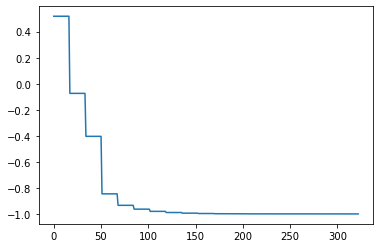

In [44]:
# plt.plot(np.imag(boltzmann.energy_optimization_history))
plt.plot(np.real(boltzmann.energy_optimization_history))